<a href="https://colab.research.google.com/github/dawidkrol/Prediction_of_electrical_energy_compsumption/blob/main/Prediction_of_electrical_energy_compsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras
!pip install keras_tuner
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import urllib.request
from matplotlib import pyplot as plt
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
from scikeras.wrappers import KerasRegressor
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import keras_tuner as kt

one_year = 24 * 365
one_month = 24 * 30
one_week = 24 * 7
one_day = 24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.1 MB/s eta 0:00:00


# Preprocessing data

In [ ]:
def normalize(df):
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

def process_input_data(dt):
  data_input = dt.copy()
  data_input['Godz.'] -= 1
  time = [datetime.strptime(str(x), '(%Y%m%d, %H)') for x in zip(data_input['Data'], data_input['Godz.'])]
  day_of_the_year = [datetime.strptime(str(x), '(%Y%m%d, %H)').timetuple().tm_yday for x in zip(data_input['Data'], data_input['Godz.'])]
  day_of_the_week = [x.weekday() for x in time]
  data_input['time'] = time
  data_input['day_of_the_year'] = day_of_the_year
  data_input['day_of_the_week'] = day_of_the_week

  data = pd.DataFrame()

  data['time'] = data_input['time']
  data['day_of_the_week'] = data_input['day_of_the_week'].astype(np.float32)
  data['current_energy_demand'] = data_input['Rzeczywiste zapotrzebowanie KSE'].astype(np.float32)/100000
  data['hour'] = data_input['Godz.'].astype(np.float32)
  data['day_of_the_year'] = data_input['day_of_the_year'].astype(np.float32)
  data['RCE'] = data_input['RCE'].astype(np.float32)/100000

  data = data.set_index('time')
  return data

In [ ]:
data_2018 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQyLPKm_djdrL4Cz-w-OsQ2QJUjiRqA-gSW-D1BLX09bF2OAdf7fjqDZpMW1IouxiV8GiY-5Reg11uL/pub?output=csv', decimal=",", thousands=",")
data_2019 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTl3NavnK7Emg1QEHIXdLLK5NfpeDzZts8qgu30g3Wlg_3yjIdB5Vf3XmUHMKNIFbMl2zq9XfCb3772/pub?output=csv', decimal=",", thousands=",")
data_2020 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSK8d9mhk0H-SgL38vWJgFpT7_Vf9VxaemoQXN3PJ02Q3EU9l0CeD6VLfzhCIajD0upPHDK1oGe2Jnh/pub?output=csv', decimal=",", thousands=",")
data_2021 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSAuH8mfWbcpOzhf-7PMBAoCwXg9bp6IxD7gJrkDJb7UNtDA4q4h0Izlyd-R9PNYK4hSzpN2GNBLrbf/pub?output=csv', decimal=",", thousands=",")
data_2022 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTGGEkWCU94jHUis6JTdUogvNG4NYLqWURqQLf3cPdyRCYbAmBcUDYjEyDDKmiMms4OE1Hz-SK1ilpp/pub?output=csv', decimal=",", thousands=",")
data_2023 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRsJOwo51grLVtH3HbS0tkckdX7uWkULxgRm8SAtBgPEkYgyjUDFqVGRU77Rrz7o5PqS0RU7q1SbCBo/pub?output=csv', decimal=",", thousands=",")

In [ ]:
data = pd.concat([process_input_data(data_2018),process_input_data(data_2019),process_input_data(data_2020),process_input_data(data_2021),process_input_data(data_2022),process_input_data(data_2023)]).sort_values(by=['time'])
data

day_of_the_week  current_energy_demand  hour  \
time                                                                
2018-01-01 00:00:00              0.0               0.149785   0.0   
2018-01-01 01:00:00              0.0               0.143977   1.0   
2018-01-01 02:00:00              0.0               0.137895   2.0   
2018-01-01 03:00:00              0.0               0.134345   3.0   
2018-01-01 04:00:00              0.0               0.132852   4.0   
...                              ...                    ...   ...   
2023-12-31 19:00:00              6.0               0.174659  19.0   
2023-12-31 20:00:00              6.0               0.165545  20.0   
2023-12-31 21:00:00              6.0               0.157054  21.0   
2023-12-31 22:00:00              6.0               0.153132  22.0   
2023-12-31 23:00:00              6.0               0.146257  23.0   

                     day_of_the_year       RCE  
time                                            
2018-01-01 00:00:00              1.0  0.001170  
2018-01-01 01:00:00              1.0  0.001140  
2018-01-01 02:00:00              1.0  0.000990  
2018-01-01 03:00:00              1.0  0.000921  
2018-01-01 04:00:00              1.0  0.000824  
...                              ...       ...  
2023-12-31 19:00:00            365.0  0.002316  
2023-12-31 20:00:00            365.0  0.001853  
2023-12-31 21:00:00            365.0  0.001950  
2023-12-31 22:00:00            365.0  0.001954  
2023-12-31 23:00:00            365.0  0.001616  

[52582 rows x 5 columns]

In [ ]:
import json

weather_2021_2022_api = urllib.request.urlopen('https://archive-api.open-meteo.com/v1/archive?latitude=50.064651&longitude=19.944981&start_date=2018-01-01&end_date=2023-12-31&hourly=temperature_2m,rain,snowfall,snow_depth,weathercode&timezone=Europe%2FBerlin').read()
op = json.loads(weather_2021_2022_api)
weather = pd.DataFrame([op['hourly']['time'],op['hourly']['temperature_2m'],op['hourly']['rain'],op['hourly']['snowfall'],op['hourly']['snow_depth'],op['hourly']['weathercode']]).T
weather.columns = ['time','temperature','rain','snowfall','snow_depth','weathercode']
weather['time'] = pd.to_datetime(weather['time'])
weather['temperature'] = weather['temperature'].astype(np.float32)
weather['rain'] = weather['rain'].astype(np.float32)
weather['snowfall'] = weather['snowfall'].astype(np.float32)
weather['snow_depth'] = weather['snow_depth'].astype(np.float32)
weather['weathercode'] = weather['weathercode'].astype(np.float32)
weather = weather.set_index('time')
weather

temperature  rain  snowfall  snow_depth  weathercode
time                                                                     
2018-01-01 00:00:00          6.2   0.0       0.0         0.0          1.0
2018-01-01 01:00:00          6.0   0.0       0.0         0.0          1.0
2018-01-01 02:00:00          5.2   0.0       0.0         0.0          1.0
2018-01-01 03:00:00          3.4   0.0       0.0         0.0          0.0
2018-01-01 04:00:00          4.1   0.0       0.0         0.0          1.0
...                          ...   ...       ...         ...          ...
2023-12-31 19:00:00          4.4   0.0       0.0         0.0          3.0
2023-12-31 20:00:00          4.9   0.0       0.0         0.0          3.0
2023-12-31 21:00:00          4.5   0.0       0.0         0.0          2.0
2023-12-31 22:00:00          3.1   0.0       0.0         0.0          2.0
2023-12-31 23:00:00          3.2   0.0       0.0         0.0          3.0

[52584 rows x 5 columns]

In [ ]:
data = data.join(weather)

In [ ]:
def build_df(data):
  one_year = 24 * 365
  one_month = 24 * 30
  one_week = 24 * 7
  one_day = 24

  mean_energy_demant_last_year = np.zeros(len(data))
  mean_energy_demant_last_month = np.zeros(len(data))
  mean_energy_demant_last_week = np.zeros(len(data))
  mean_energy_demant_last_day = np.zeros(len(data))

  rce_last_year = np.zeros(len(data))
  rce_last_month = np.zeros(len(data))
  rce_last_week = np.zeros(len(data))
  rce_last_day = np.zeros(len(data))

  temperature_last_year = np.zeros(len(data))
  temperature_last_month = np.zeros(len(data))
  temperature_last_week = np.zeros(len(data))
  temperature_last_day = np.zeros(len(data))

  for i in range(one_year, len(data)):
    mean_energy_demant_last_year[i] = np.mean(data['current_energy_demand'][i:i+one_year])
    rce_last_year[i] = np.mean(data['RCE'][i:i+one_year])
    temperature_last_year[i] = np.mean(data['temperature'][i:i+one_year])

  for i in range(one_month, len(data)):
    mean_energy_demant_last_month[i] = np.mean(data['current_energy_demand'][i:i+one_month])
    rce_last_month[i] = np.mean(data['RCE'][i:i+one_month])
    temperature_last_month[i] = np.mean(data['temperature'][i:i+one_month])

  for i in range(one_week, len(data)):
    mean_energy_demant_last_week[i] = np.mean(data['current_energy_demand'][i:i+one_week])
    rce_last_week[i] = np.mean(data['RCE'][i:i+one_week])
    temperature_last_week[i] = np.mean(data['temperature'][i:i+one_week])

  for i in range(one_day, len(data)):
    mean_energy_demant_last_day[i] = np.mean(data['current_energy_demand'][i:i+one_day])
    rce_last_day[i] = np.mean(data['RCE'][i:i+one_day])
    temperature_last_day[i] = np.mean(data['temperature'][i:i+one_day])

  new_df = pd.DataFrame(index=data.index)
  new_df['mean_energy_demant_last_year'] = mean_energy_demant_last_year
  new_df['mean_energy_demant_last_month'] = mean_energy_demant_last_month
  new_df['mean_energy_demant_last_week'] = mean_energy_demant_last_week
  new_df['mean_energy_demant_last_day'] = mean_energy_demant_last_day
  new_df['current_energy_demand'] = data['current_energy_demand']

  new_df['mean_rce_last_year'] = rce_last_year
  new_df['mean_energy_demant_last_month'] = rce_last_month
  new_df['mean_energy_demant_last_week'] = rce_last_week
  new_df['mean_energy_demant_last_day'] = rce_last_day
  new_df['RCE'] = data['RCE']

  new_df['temperature_last_year'] = temperature_last_year
  new_df['temperature_last_month'] = temperature_last_month
  new_df['temperature_last_week'] = temperature_last_week
  new_df['temperature_last_day'] = temperature_last_day
  new_df['temperature'] = data['temperature']

  new_df['hour'] = data['hour']
  new_df['day_of_the_week'] = data['day_of_the_week']
  new_df['day_of_the_year'] = data['day_of_the_year']
  new_df['rain'] = data['rain']
  new_df['snowfall'] = data['snowfall']
  new_df['snow_depth'] = data['snow_depth']
  new_df['weathercode'] = data['weathercode']

  return new_df

In [ ]:
data = build_df(data)
data.to_excel('prev_data.xlsx')

In [ ]:
def convertToMatrix(data, step):
    X =[]
    for i in range(len(data)-step):
        d=i+step
        X.append(data[i:d,])
    return np.array(X)

# Hourly Model

In [ ]:
# cnt_train = data[['current_energy_demand', 'hour','day_of_the_week','temperature','rain','snowfall','snow_depth','weathercode']]['2021-01-01 00:00':'2021-12-31 23:00']
# cnt_valid = data[['current_energy_demand', 'hour','day_of_the_week','temperature','rain','snowfall','snow_depth','weathercode']]['2022-01-01 00:00':]

cnt_train = data[['current_energy_demand','day_of_the_week','hour','temperature','day_of_the_year','RCE']]['2018-01-01 00:00':'2023-01-01 23:00']
cnt_valid = data[['current_energy_demand','day_of_the_week','hour', 'temperature','day_of_the_year','RCE']]['2023-01-02 00:00':'2023-07-31 23:00']

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=cnt_train[['day_of_the_week','hour','day_of_the_year','temperature','RCE']].to_numpy(),
    targets=cnt_train[['current_energy_demand']].to_numpy(),
    sequence_length=24,
    batch_size=32,
    shuffle=True,
    seed=42
    )
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    cnt_valid[['day_of_the_week','hour','day_of_the_year','temperature','RCE']].to_numpy(),
    targets=cnt_valid[['current_energy_demand']].to_numpy(),
    sequence_length=24,
    batch_size=32
    )

In [ ]:
hourly_model = tf.keras.Sequential([
    keras.layers.LSTM(64, input_shape=(1, 5), return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32, name='RNN_3'),
    keras.layers.Dense(64, name='Dense_2', activation='relu'),
    keras.layers.Dense(1, activation='relu')
    ])


# model.compile(
#     optimizer=tf.keras.optimizers.experimental.SGD(momentum=0.9),
#     loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
#     metrics=["mae"])

hourly_model.compile(optimizer='adam', loss='mean_squared_error',metrics=["mae"])

hourly_model.summary()

TypeError: ignored

In [ ]:
hourly_history = hourly_model.fit(train_ds, epochs=20, validation_data=valid_ds)

Epoch 1/20
1370/1370 [==============================] - 26s 16ms/step - loss: 3.9281e-04 - mae: 0.0147 - val_loss: 1.7802e-04 - val_mae: 0.0100
Epoch 2/20
1370/1370 [==============================] - 21s 15ms/step - loss: 2.0192e-04 - mae: 0.0104 - val_loss: 1.6465e-04 - val_mae: 0.0092
Epoch 3/20
1370/1370 [==============================] - 21s 15ms/step - loss: 1.7824e-04 - mae: 0.0095 - val_loss: 1.3220e-04 - val_mae: 0.0082
Epoch 4/20
1370/1370 [==============================] - 21s 15ms/step - loss: 1.6625e-04 - mae: 0.0091 - val_loss: 1.1409e-04 - val_mae: 0.0076
Epoch 5/20
1370/1370 [==============================] - 19s 14ms/step - loss: 1.6040e-04 - mae: 0.0089 - val_loss: 1.6176e-04 - val_mae: 0.0090
Epoch 6/20
1370/1370 [==============================] - 19s 14ms/step - loss: 1.5242e-04 - mae: 0.0086 - val_loss: 1.5003e-04 - val_mae: 0.0087
Epoch 7/20
1370/1370 [==============================] - 20s 15ms/step - loss: 1.4827e-04 - mae: 0.0084 - val_loss: 1.2526e-04 - val_mae:

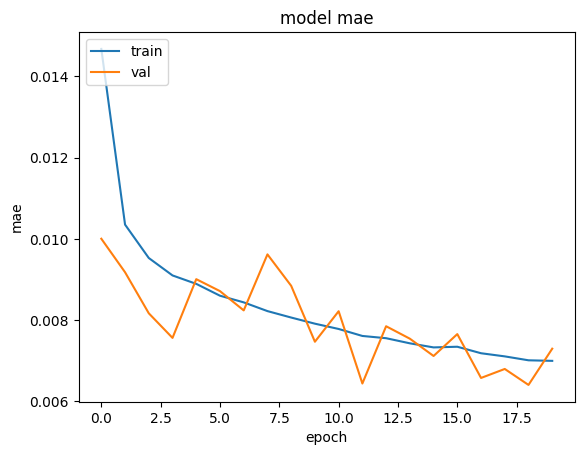

In [ ]:
plt.plot(hourly_history.history['mae'])
plt.plot(hourly_history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
!pip install scikeras
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
def build_model(hp):
  n_hidden_LSTM = hp.Int("n_hidden_LSTM", min_value=1, max_value=5, default=2)
  n_hidden_Dense = hp.Int("n_hidden_Dense", min_value=1, max_value=5, default=2)
  n_neurons = hp.Int("n_neurons", min_value=40, max_value=190)

  learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

  # optimizer = hp.Choice("optimizer", values=["sgd", "adam"])

  # if optimizer == "sgd":
  #   optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  # else:
  #   optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model = tf.keras.Sequential()
  model.add(keras.layers.LSTM(n_neurons, input_shape=(1, 5), return_sequences=True))
  for _ in range(n_hidden_LSTM):
    model.add(keras.layers.LSTM(n_neurons, return_sequences=True))

  model.add(keras.layers.LSTM(n_neurons))

  for _ in range(n_hidden_Dense):
    # Dodać prrrzy epochs > 100
    # model.add(keras.layers.BatchNormalization())
    # model.add(keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

  model.add(keras.layers.Dense(1))


  model.compile(loss="mean_squared_error", optimizer=optimizer,
      metrics=["mae"])

  return model

random_search_tuner = kt.RandomSearch(
  build_model, objective="val_mae", max_trials=4, overwrite=True,
  directory="pred_dict", project_name="daily_energy_compsumption", seed=42)
random_search_tuner.search(train_ds, epochs=15,
  validation_data=valid_ds)

hourly_model = random_search_tuner.get_best_models(num_models=1)[0]

Trial 1 Complete [00h 08m 15s]
val_mae: 0.01758383773267269

Best val_mae So Far: 0.01758383773267269
Total elapsed time: 00h 08m 15s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
5                 |4                 |n_hidden_LSTM
2                 |1                 |n_hidden_Dense
122               |101               |n_neurons
0.00013607        |0.00034974        |learning_rate

Epoch 1/15
1370/1370 [==============================] - 51s 28ms/step - loss: 0.0792 - mae: 0.1962 - val_loss: 0.0054 - val_mae: 0.0587
Epoch 2/15
1370/1370 [==============================] - 35s 25ms/step - loss: 0.0203 - mae: 0.1037 - val_loss: 0.0031 - val_mae: 0.0385
Epoch 3/15
1370/1370 [==============================] - 36s 26ms/step - loss: 0.0104 - mae: 0.0749 - val_loss: 0.0023 - val_mae: 0.0399
Epoch 4/15
1370/1370 [==============================] - 36s 27ms/step - loss: 0.0058 - mae: 0.0566 - val_loss: 0.0025 - val_mae: 0.0382
Epoch 5/15
1370/1370 [==============

KeyboardInterrupt: ignored

In [ ]:
hourly_model.save('hourly/hourly_151123.h5')
# hourly_model = keras.models.load_model('model071123.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
val_mae = hourly_model.evaluate(valid_ds, verbose=0)[1] * 10**3
val_mae

7.294988259673119

In [ ]:
def predict_hourly(start, end, step = 24):
  prd = datetime.strptime(str(start), '%Y-%m-%d %H:%M')
  prd = prd - timedelta(days=1)
  trainX = data[['day_of_the_week','hour','day_of_the_year','temperature','RCE']][prd:end].to_numpy()
  trainY = data[['current_energy_demand']][start:end].to_numpy()
  trainX = convertToMatrix(trainX,step)

  trainPredict = hourly_model.predict(trainX)
  return trainPredict

def predict_hourly_plot(start, end, step = 24):
  trainPredict = predict_hourly(start, end, step)
  p = datetime.strptime(str(start), '%Y-%m-%d %H:%M')
  k = datetime.strptime(str(end), '%Y-%m-%d %H:%M')

  x = data[start:end].index.values
  trainY = data[['current_energy_demand']][str(p - timedelta(days=1)):str(k - timedelta(days=1))].to_numpy()

  plt.figure(figsize=(20,5))
  plt.plot(x,trainPredict*100000, label = "prediction")
  plt.plot(x,trainY*100000, 'r--', label = "real")
  plt.grid()
  plt.legend()
  plt.show()

  hourly_mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(
      trainPredict*100000,trainY*100000
  ))
  print('hourly mape: ', hourly_mape)

  return trainPredict*100000,trainY*100000

In [ ]:
mmpe = predict_hourly_plot('2023-09-20 00:00','2023-09-30 00:00')

ValueError: ignored

1/1 [==============================] - 0s 33ms/step


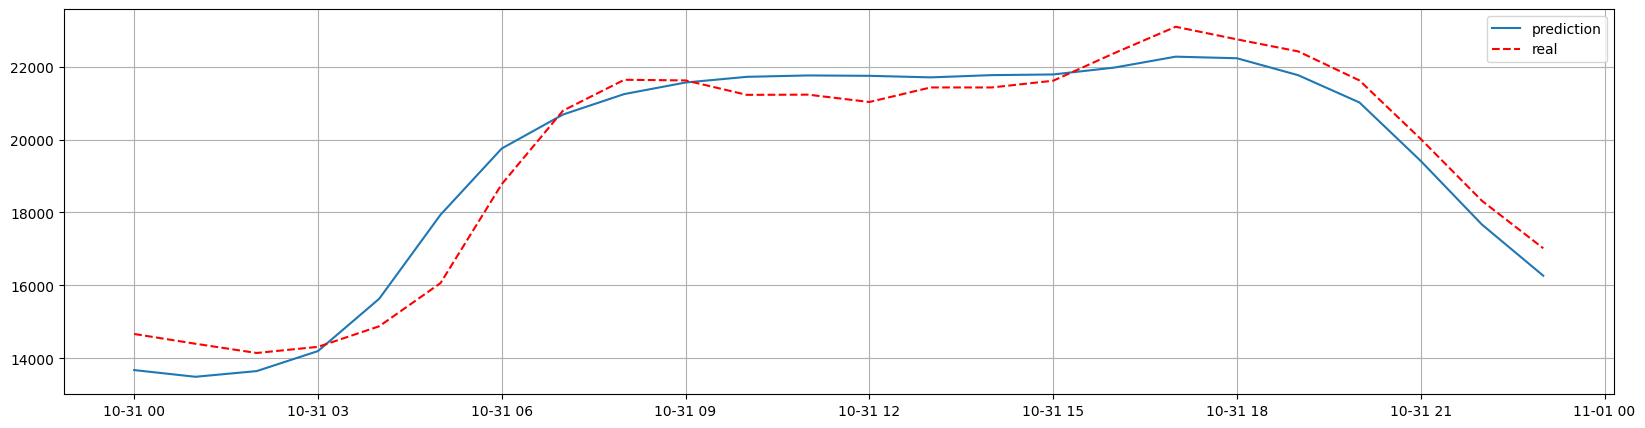

hourly mape:  3.2489146219922334


In [ ]:
mape1 = predict_hourly_plot('2023-10-31 00:00','2023-10-31 23:00')

28/28 [==============================] - 0s 6ms/step


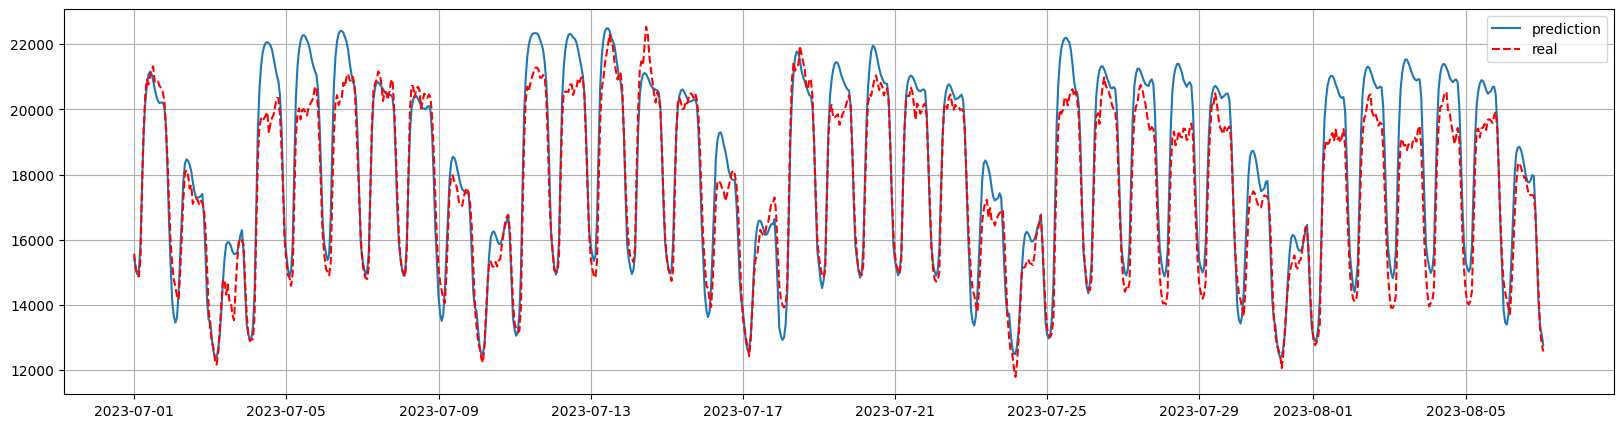

hourly mape:  3.725722826619533


In [ ]:
mape0 = predict_hourly_plot('2023-07-01 00:00','2023-08-07 01:00')

274/274 [==============================] - 1s 5ms/step


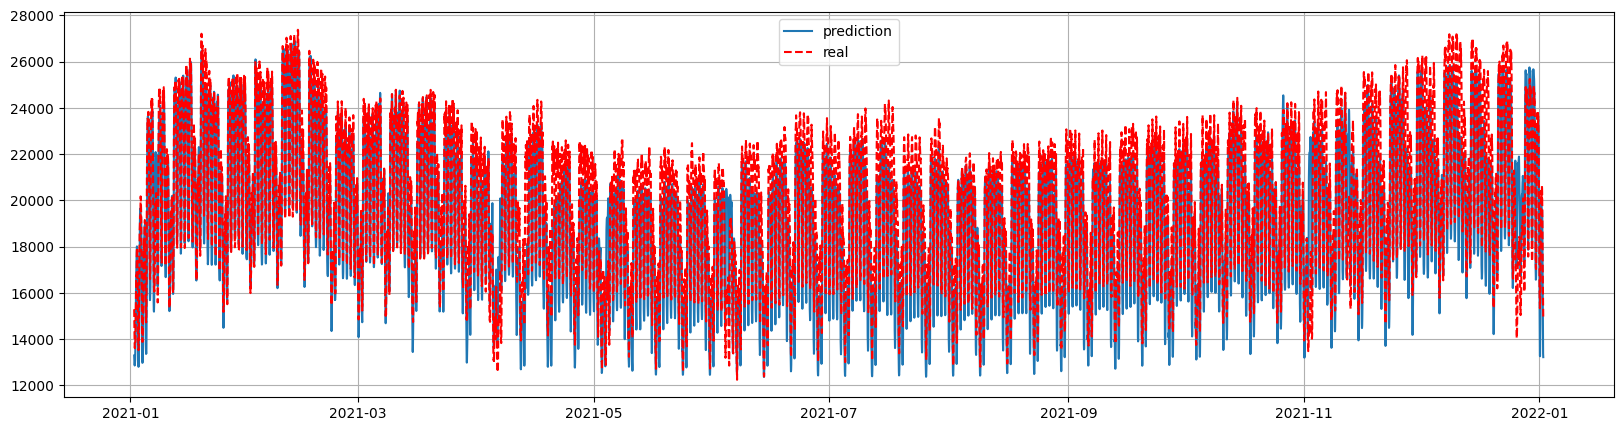

hourly mape:  5.136824833768941


In [ ]:
mape1 = predict_hourly_plot('2021-01-02 00:00','2022-01-02 00:00')

# Daily Model

In [ ]:
sequence_length = 24
y = np.zeros((len(data),24))

for i in range(len(data) - sequence_length):
    y[i]=data['current_energy_demand'][i:i+sequence_length].astype(np.float32).to_numpy()


cnt_train = data[['current_energy_demand','day_of_the_week','hour','temperature','day_of_the_year','RCE']][:'2023-01-01 23:00']
cnt_valid = data[['current_energy_demand','day_of_the_week','hour', 'temperature','day_of_the_year','RCE']]['2023-01-02 00:00':'2023-07-31 23:00']

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=cnt_train[['day_of_the_week','hour','day_of_the_year','temperature','RCE']].to_numpy(),
    targets=y[0:len(cnt_train)],
    sequence_length=24,
    batch_size=32,
    shuffle=True,
    seed=42
    )
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    cnt_valid[['day_of_the_week','hour','day_of_the_year','temperature','RCE']].to_numpy(),
    targets=y[len(cnt_train):len(cnt_valid)+len(cnt_train)],
    sequence_length=24,
    batch_size=32
    )


In [ ]:
daily_model = tf.keras.Sequential([
    keras.layers.LSTM(64, input_shape=(None, 5), return_sequences=True, name='LSTM_1'),
    keras.layers.LSTM(64, return_sequences=True,  name='LSTM_2'),
    keras.layers.LSTM(32,  name='LSTM_3'),
    keras.layers.Dense(64, name='Dense_1'),
    keras.layers.Dense(24, name='Dense_Output')

    ])

daily_model.compile(optimizer='adam', loss='mean_squared_error',metrics=["mae"])

daily_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, None, 64)          17920     
                                                                 
 LSTM_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 LSTM_3 (LSTM)               (None, 32)                12416     
                                                                 
 Dense_1 (Dense)             (None, 64)                2112      
                                                                 
 Dense_Output (Dense)        (None, 24)                1560      
                                                                 
Total params: 67032 (261.84 KB)
Trainable params: 67032 (261.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
daily_history = daily_model.fit(train_ds, epochs=10, validation_data=valid_ds)

Epoch 1/10
1370/1370 [==============================] - 43s 28ms/step - loss: 5.5449e-04 - mae: 0.0163 - val_loss: 1.7554e-04 - val_mae: 0.0096
Epoch 2/10
1370/1370 [==============================] - 37s 27ms/step - loss: 1.8806e-04 - mae: 0.0099 - val_loss: 2.2337e-04 - val_mae: 0.0111
Epoch 3/10
1370/1370 [==============================] - 38s 27ms/step - loss: 1.6750e-04 - mae: 0.0091 - val_loss: 1.4951e-04 - val_mae: 0.0087
Epoch 4/10
1370/1370 [==============================] - 36s 26ms/step - loss: 1.5801e-04 - mae: 0.0088 - val_loss: 1.7423e-04 - val_mae: 0.0094
Epoch 5/10
1370/1370 [==============================] - 36s 26ms/step - loss: 1.5351e-04 - mae: 0.0086 - val_loss: 1.6388e-04 - val_mae: 0.0090
Epoch 6/10
1370/1370 [==============================] - 45s 33ms/step - loss: 1.4581e-04 - mae: 0.0083 - val_loss: 1.7494e-04 - val_mae: 0.0095
Epoch 7/10
1370/1370 [==============================] - 36s 26ms/step - loss: 1.4011e-04 - mae: 0.0080 - val_loss: 1.3318e-04 - val_mae:

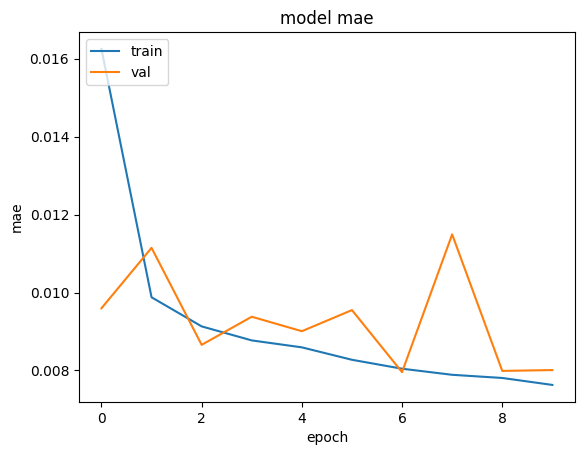

In [ ]:
plt.plot(daily_history.history['mae'])
plt.plot(daily_history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_mae = daily_model.evaluate(valid_ds, verbose=0)[1] * 10**3
val_mae

8.009822107851505

In [ ]:
daily_model.save('daily_01_02.h5')
# daily_model = keras.models.load_model('daily_091123.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def predict_daily(date_to_predict, step = 24):
  pred_day_start = datetime.strptime(str(date_to_predict), '%Y-%m-%d %H:%M')
  prd = pred_day_start - timedelta(hours=one_day)
  trainX = data[['day_of_the_week','hour','day_of_the_year','temperature','RCE']][prd:pred_day_start].to_numpy()
  trainX = convertToMatrix(trainX,step)
  trainPredict = daily_model.predict(trainX).reshape((one_day,))
  return trainPredict

def predict_daily_plot(date_to_predict, step = 24):
  pred_day_start = datetime.strptime(str(date_to_predict), '%Y-%m-%d %H:%M')
  trainY = data[['current_energy_demand']][pred_day_start:pred_day_start + timedelta(hours=one_day - 1)].to_numpy().reshape((one_day,))

  trainPredict = predict_daily(date_to_predict, step)

  # x = data[pred_day_start:pred_day_start + timedelta(hours=one_day - 1)].index.values
  x = [pred_day_start + timedelta(hours=i) for i in range(one_day)]

  plt.figure(figsize=(50,5))
  hours = mdates.HourLocator(interval=1)
  plt.gca().xaxis.set_major_locator(hours)
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
  plt.xticks(rotation=45, ha='right')
  plt.plot(x,trainPredict*100000, label = "prediction")
  plt.plot(x,trainY*100000, 'r--', label = "real")
  plt.grid()
  plt.legend()
  plt.show()
  daily_mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(
    trainPredict*100000,trainY*100000
  ))
  print('daily mape: ', daily_mape)
  return trainPredict*100000,trainY*100000

def predict_daily_vs_hourly(date_to_predict, step = 24):
  pred_day_start = datetime.strptime(str(date_to_predict), '%Y-%m-%d %H:%M')
  trainY = data[['current_energy_demand']][pred_day_start:pred_day_start + timedelta(hours=2)].to_numpy().reshape((24,))

  hourly_pred = predict_hourly(date_to_predict,str(pred_day_start + timedelta(hours=23)),24).reshape((24,))
  trainPredict = predict_daily(date_to_predict, step)
  x = data[pred_day_start:pred_day_start + timedelta(hours=23)].index.values

  plt.figure(figsize=(70,5))
  plt.plot(x,trainPredict*100000, label = "daily prediction")
  plt.plot(x,hourly_pred*100000, label = "hourly prediction")
  plt.plot(x,trainY*100000, 'r--', label = "real")
  plt.grid()
  plt.legend()
  plt.show()
  daily_mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(
      trainPredict*100000, trainY*100000
  ))
  hourly_mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(
      hourly_pred*100000, trainY*100000
  ))
  print('daily mape: ', daily_mape, '\n', 'hourly mape: ', hourly_mape)
  return trainPredict*100000,trainY*100000,hourly_pred*100000

1/1 [==============================] - 0s 29ms/step


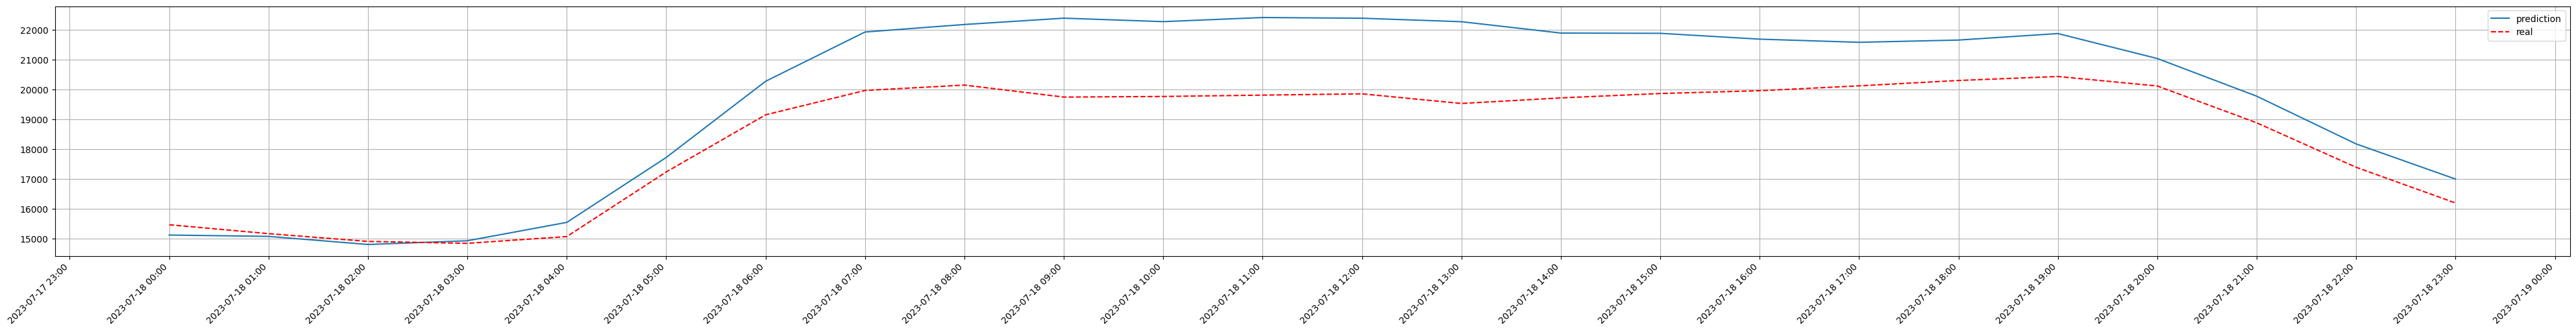

daily mape:  6.520221824587287


In [ ]:
mape_daily_1 = predict_daily_plot('2023-07-18 00:00')

In [ ]:
mape_daily_2 = predict_daily_vs_hourly('2023-09-25 00:00')

NameError: name 'predict_hourly' is not defined

# Monthly Model - 30 days

In [ ]:
sequence_length = one_month

y = np.zeros((len(data),one_month))

for i in range(len(data) - sequence_length):
    y[i]=data['current_energy_demand'][i + 1 : i + 1 + sequence_length].astype(np.float32).to_numpy()


cnt_train = data[['current_energy_demand','day_of_the_week','hour','temperature','day_of_the_year','RCE']]['2018-01-02 00:00':'2023-01-01 23:00']
cnt_valid = data[['current_energy_demand','day_of_the_week','hour', 'temperature','day_of_the_year','RCE']]['2023-01-02 00:00':'2023-07-31 23:00']

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=cnt_train[['current_energy_demand','day_of_the_week','hour','day_of_the_year','temperature','RCE']].to_numpy(),
    targets=y[48:len(cnt_train) + 48],
    sequence_length=24,
    batch_size=32,
    shuffle=True,
    seed=42
    )
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    cnt_valid[['current_energy_demand','day_of_the_week','hour','day_of_the_year','temperature','RCE']].to_numpy(),
    targets=y[48 + len(cnt_train) : 48 + len(cnt_valid) + len(cnt_train)],
    sequence_length=24,
    batch_size=32
    )

In [ ]:
monthly_model = tf.keras.Sequential([
    keras.layers.LSTM(64, input_shape=(None, 6), return_sequences=True, name='LSTM_1'),
    keras.layers.LSTM(64, return_sequences=True,  name='LSTM_2'),
    keras.layers.LSTM(32,  name='LSTM_3'),
    keras.layers.Dense(64, name='Dense_1'),
    keras.layers.Dense(24*30, name='Dense_Output')

    ])

monthly_model.compile(optimizer='adam', loss='mean_squared_error',metrics=["mae"])

monthly_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, None, 64)          18176     
                                                                 
 LSTM_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 LSTM_3 (LSTM)               (None, 32)                12416     
                                                                 
 Dense_1 (Dense)             (None, 64)                2112      
                                                                 
 Dense_Output (Dense)        (None, 720)               46800     
                                                                 
Total params: 112528 (439.56 KB)
Trainable params: 112528 (439.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
monthly_history = monthly_model.fit(train_ds, epochs=15, validation_data=valid_ds)

Epoch 1/15
1369/1369 [==============================] - 42s 27ms/step - loss: 8.7224e-04 - mae: 0.0213 - val_loss: 2.8019e-04 - val_mae: 0.0128
Epoch 2/15
1369/1369 [==============================] - 41s 30ms/step - loss: 2.5772e-04 - mae: 0.0119 - val_loss: 2.0394e-04 - val_mae: 0.0107
Epoch 3/15
1369/1369 [==============================] - 37s 27ms/step - loss: 2.1180e-04 - mae: 0.0105 - val_loss: 1.7866e-04 - val_mae: 0.0099
Epoch 4/15
1369/1369 [==============================] - 37s 27ms/step - loss: 1.9536e-04 - mae: 0.0099 - val_loss: 1.8158e-04 - val_mae: 0.0100
Epoch 5/15
1369/1369 [==============================] - 37s 27ms/step - loss: 1.8749e-04 - mae: 0.0096 - val_loss: 2.0654e-04 - val_mae: 0.0108
Epoch 6/15
1369/1369 [==============================] - 36s 26ms/step - loss: 1.8345e-04 - mae: 0.0095 - val_loss: 1.7549e-04 - val_mae: 0.0097
Epoch 7/15
1369/1369 [==============================] - 36s 27ms/step - loss: 1.7872e-04 - mae: 0.0093 - val_loss: 1.9080e-04 - val_mae:

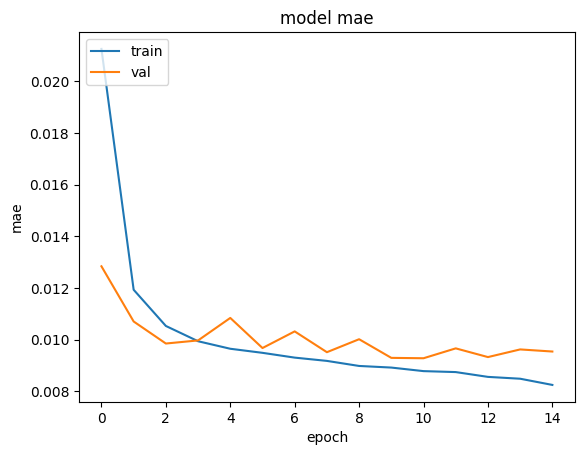

In [ ]:
plt.plot(monthly_history.history['mae'])
plt.plot(monthly_history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
monthly_model.save('monthly_01_02.h5')
# monthly_model = keras.models.load_model('daily_091123.h5')

In [ ]:
val_mae = monthly_model.evaluate(valid_ds, verbose=0)[1] * 10**3
val_mae

9.540644474327564

In [ ]:
def predict_monthly(date_to_predict, step = 24):
  pred_day_start = datetime.strptime(str(date_to_predict), '%Y-%m-%d %H:%M')
  prd = pred_day_start - timedelta(hours=24)
  trainX = data[['current_energy_demand','day_of_the_week','hour','day_of_the_year','temperature','RCE']][prd:pred_day_start].to_numpy()
  trainX = convertToMatrix(trainX,step)
  trainPredict = monthly_model.predict(trainX).reshape((one_month,))
  return trainPredict

def predict_monthly_plot(date_to_predict, step = 24):
  pred_day_start = datetime.strptime(str(date_to_predict), '%Y-%m-%d %H:%M')
  trainY = data[['current_energy_demand']][pred_day_start:pred_day_start + timedelta(hours=one_month - 1)].to_numpy().reshape((one_month,))

  trainPredict = predict_monthly(date_to_predict, step)

  x = data[pred_day_start:pred_day_start + timedelta(hours=one_month - 1)].index.values

  plt.figure(figsize=(35,10))
  import matplotlib.dates as mdates ## Import required library
  months = mdates.DayLocator(interval=1)  ## 1 month apart & show last date
  plt.gca().xaxis.set_major_locator(months) ## Set months as major locator
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) ##Display format - update here to change
  plt.xticks(rotation=45, ha='right')
  plt.plot(x,trainPredict*100000, label = "prediction")
  plt.plot(x,trainY*100000, 'r--', label = "real")
  plt.legend()
  plt.grid()
  plt.show()
  daily_mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(
    trainPredict*100000,trainY*100000
  ))
  print('monthly mape: ', daily_mape)
  return trainPredict*100000,trainY*100000

1/1 [==============================] - 0s 18ms/step


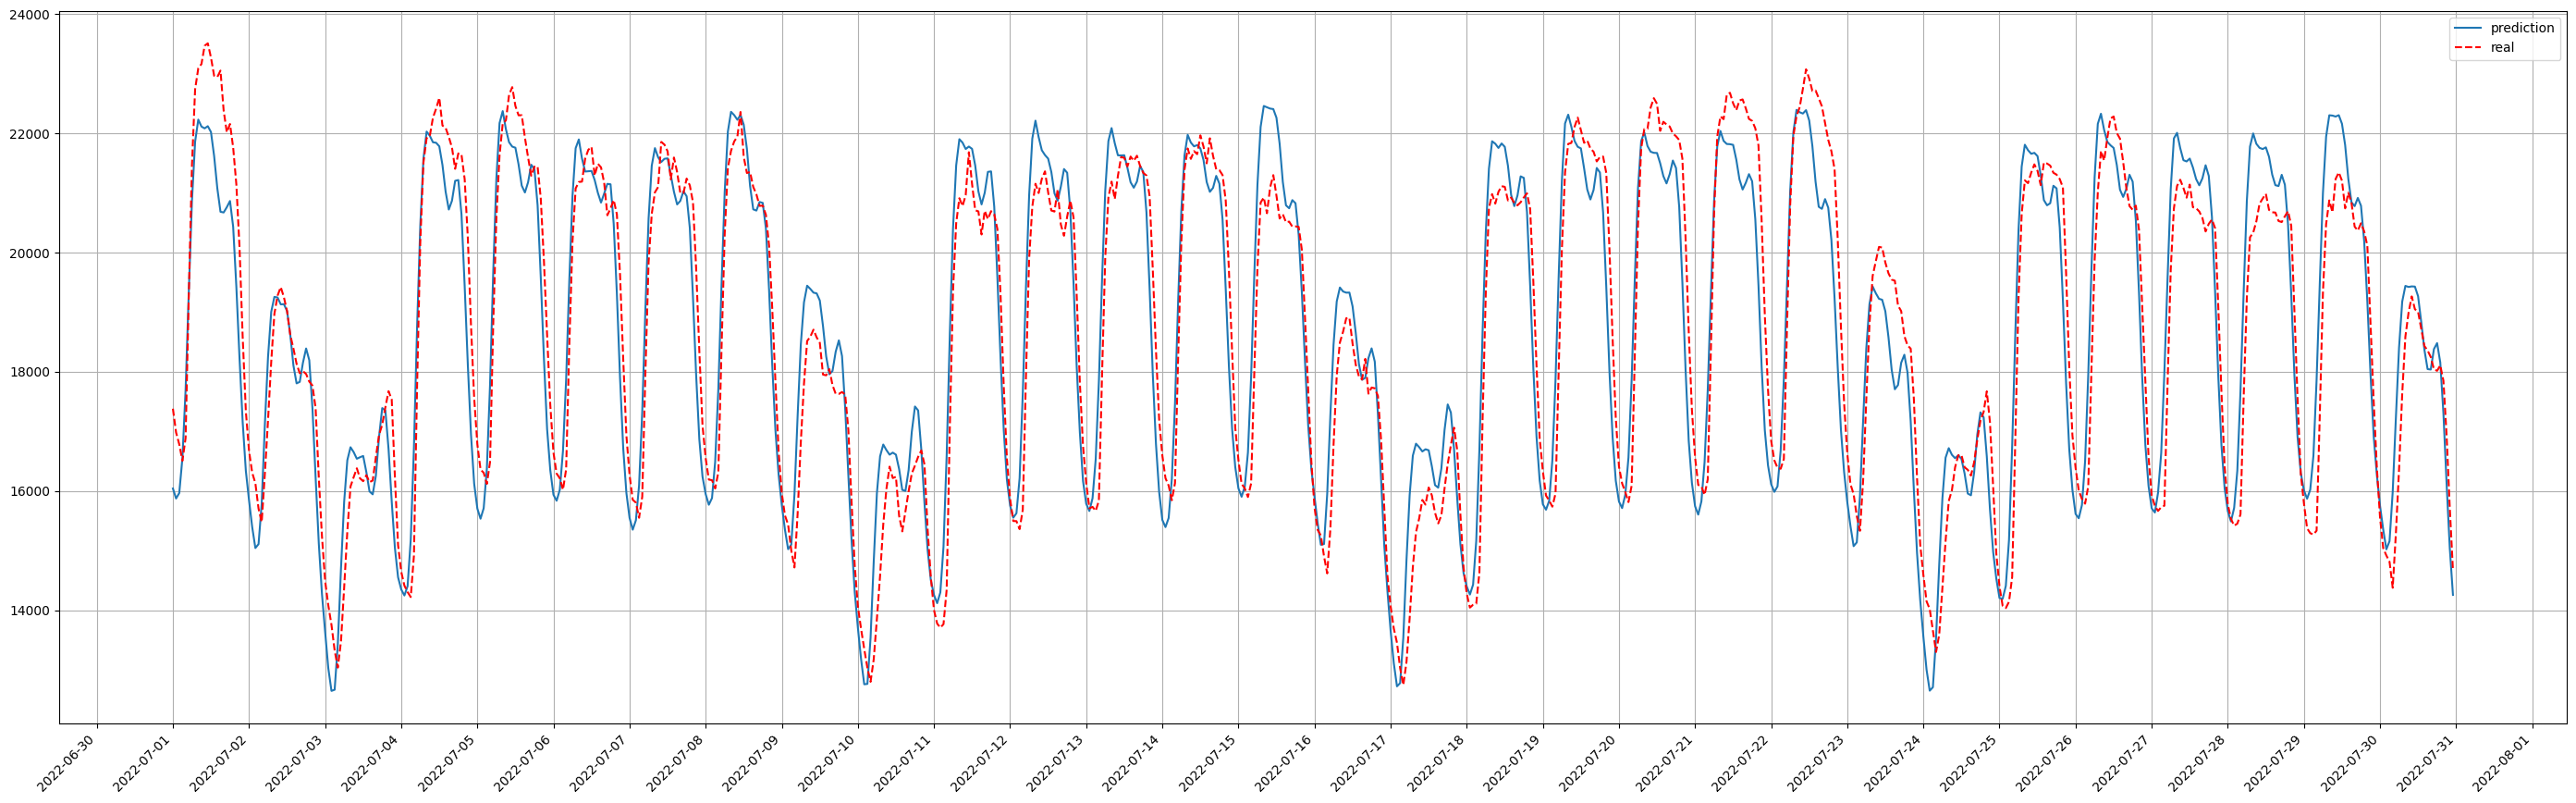

monthly mape:  4.176915529705781


In [ ]:
mape_monthlyy_1 = predict_monthly_plot('2022-07-01 00:00')

# Yearly Model - 365 days

In [ ]:
# data = pd.read_excel('data.xlsx')
# data = data.set_index('time')

In [ ]:
data.corr()["current_energy_demand"]

In [ ]:
cnt_train = data['2018-01-02 00:00':'2022-07-01 23:00']
cnt_valid = data['2022-07-02 00:00':'2022-10-01 23:00']

y = np.zeros((len(data),one_year))

for i in range(0, len(data) - one_year):
    y[i]=data['current_energy_demand'][i + 1:i + one_year + 1].astype(np.float32).to_numpy()

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=cnt_train.to_numpy(),
    targets=y[48 : len(cnt_train) + 48],
    sequence_length=24,
    batch_size=32,
    shuffle=True,
    seed=42
    )
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    cnt_valid.to_numpy(),
    targets=y[48 + len(cnt_train):len(cnt_valid) + len(cnt_train) + 48],
    sequence_length=24,
    batch_size=32
    )

In [ ]:
annual_model = tf.keras.Sequential([
    keras.layers.LSTM(128, input_shape=(None, 19), return_sequences=True, name='LSTM_1'),
    keras.layers.LSTM(128, return_sequences=True,  name='LSTM_2'),
    keras.layers.LSTM(64,  name='LSTM_3'),
    keras.layers.Dense(256, name='Dense_1'),
    keras.layers.Dense(128, name='Dense_2'),
    keras.layers.Dense(24*365, name='Dense_Output')
    ])

annual_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error',metrics=["mae"])

annual_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, None, 128)         75776     
                                                                 
 LSTM_2 (LSTM)               (None, None, 128)         131584    
                                                                 
 LSTM_3 (LSTM)               (None, 64)                49408     
                                                                 
 Dense_1 (Dense)             (None, 256)               16640     
                                                                 
 Dense_2 (Dense)             (None, 128)               32896     
                                                                 
 Dense_Output (Dense)        (None, 8760)              1130040   
                                                                 
Total params: 1436344 (5.48 MB)
Trainable params: 143634

In [ ]:
annual_history = annual_model.fit(train_ds, epochs=25, validation_data=valid_ds)

Epoch 1/25
1231/1231 [==============================] - 90s 69ms/step - loss: 7.7187e-04 - mae: 0.0205 - val_loss: 3.6346e-04 - val_mae: 0.0144
Epoch 2/25
1231/1231 [==============================] - 83s 68ms/step - loss: 2.6018e-04 - mae: 0.0118 - val_loss: 2.6905e-04 - val_mae: 0.0120
Epoch 3/25
1231/1231 [==============================] - 82s 67ms/step - loss: 2.1113e-04 - mae: 0.0103 - val_loss: 2.4612e-04 - val_mae: 0.0113
Epoch 4/25
1231/1231 [==============================] - 90s 73ms/step - loss: 1.8425e-04 - mae: 0.0095 - val_loss: 2.1683e-04 - val_mae: 0.0107
Epoch 5/25
1231/1231 [==============================] - 83s 68ms/step - loss: 1.7273e-04 - mae: 0.0091 - val_loss: 2.0913e-04 - val_mae: 0.0104
Epoch 6/25
1231/1231 [==============================] - 83s 68ms/step - loss: 1.5741e-04 - mae: 0.0086 - val_loss: 2.0501e-04 - val_mae: 0.0103
Epoch 7/25
1231/1231 [==============================] - 82s 67ms/step - loss: 1.5343e-04 - mae: 0.0084 - val_loss: 1.9458e-04 - val_mae:

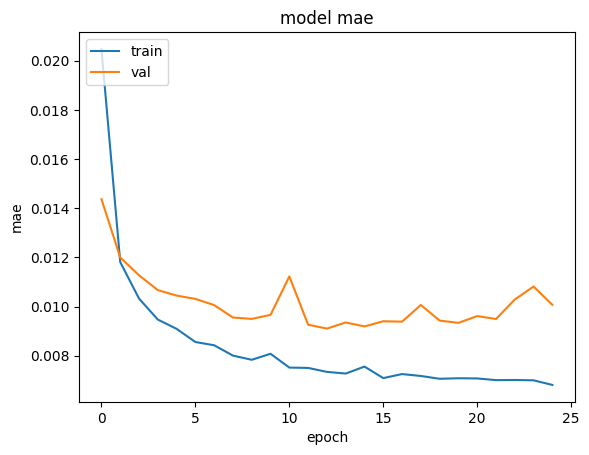

In [ ]:
plt.plot(annual_history.history['mae'])
plt.plot(annual_history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def build_model(hp):
  n_hidden_LSTM = hp.Int("n_hidden_LSTM", min_value=1, max_value=5, default=2)
  n_hidden_Dense = hp.Int("n_hidden_Dense", min_value=1, max_value=5, default=2)
  n_neurons_LSTM = hp.Int("n_neurons_LSTM", min_value=32, max_value=200)
  n_neurons_Dense = hp.Int("n_neurons_Dense", min_value=32, max_value=200)

  learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

  # optimizer = hp.Choice("optimizer", values=["sgd", "adam"])

  # if optimizer == "sgd":
  #   optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  # else:
  #   optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  model = tf.keras.Sequential()
  keras.layers.LSTM(n_neurons_LSTM, input_shape=(None, 19), return_sequences=True)
  for _ in range(n_hidden_LSTM):
    model.add(keras.layers.LSTM(n_neurons_LSTM, return_sequences=True))

  model.add(keras.layers.LSTM(n_neurons_LSTM))

  for _ in range(n_hidden_Dense):
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.15))
    model.add(tf.keras.layers.Dense(n_neurons_Dense, activation="relu"))

  model.add(keras.layers.Dense(24*365, name='Dense_Output'))


  model.compile(loss="mean_squared_error", optimizer=optimizer,
      metrics=["mae"])

  return model

random_search_tuner = kt.RandomSearch(
  build_model, objective="val_mae", cv=5, max_trials=15, overwrite=True,
  directory="pred_dict", project_name="daily_energy_compsumption", seed=42)

# Warto zauważyć, że cv=5 oznacza kroswalidację 5-krotną, co oznacza, że dane są dzielone na 5 części,
# a model trenowany jest 5 razy, używając innej części jako zbioru testowego w każdym przypadku.
# To pomaga w uzyskaniu bardziej ogólnej oceny modelu.

random_search_tuner.search(train_ds, epochs=50,
  validation_data=valid_ds)

annual_model = random_search_tuner.get_best_models(num_models=1)[0]

ValueError: Unrecognized arguments ['cv'] for `BaseTuner.__init__()`.

In [ ]:
# annual_model.save('annual_01_02_v2.h5')
annual_model = keras.models.load_model('annual_01_02_v2.h5')

In [ ]:
def predict_annualy(date_to_predict, step = 24):
  pred_day_start = datetime.strptime(str(date_to_predict), '%Y-%m-%d %H:%M')
  prd = pred_day_start - timedelta(hours=24)
  trainX = data[prd:pred_day_start].to_numpy()
  trainX = convertToMatrix(trainX,step)
  trainPredict = annual_model.predict(trainX).reshape((one_year,))
  return trainPredict

def predict_annualy_plot(date_to_predict, step = 24):
  pred_day_start = datetime.strptime(str(date_to_predict), '%Y-%m-%d %H:%M')
  start_index = data.index.get_loc(pred_day_start) + 1
  trainY = data[['current_energy_demand']].iloc[start_index:start_index + one_year].to_numpy().reshape((one_year,))

  trainPredict = predict_annualy(date_to_predict, step)

  x = data.iloc[start_index:start_index + one_year].index.values
  # x = [pred_day_start + timedelta(hours=i) + timedelta(hours=1) for i in range(one_year)]

  plt.figure(figsize=(600,7))
  months = mdates.DayLocator(interval=1)
  plt.gca().xaxis.set_major_locator(months)
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
  plt.xticks(rotation=45, ha='right')
  plt.plot(x,trainPredict*100000, label = "prediction")
  plt.plot(x,trainY*100000, 'r--', label = "real")
  plt.legend()
  plt.grid()
  plt.show()
  daily_mape = np.mean(tf.keras.metrics.mean_absolute_percentage_error(
    trainPredict*100000,trainY*100000
  ))
  print('annual mape: ', daily_mape)
  return trainPredict*100000,trainY*100000

1/1 [==============================] - 0s 41ms/step


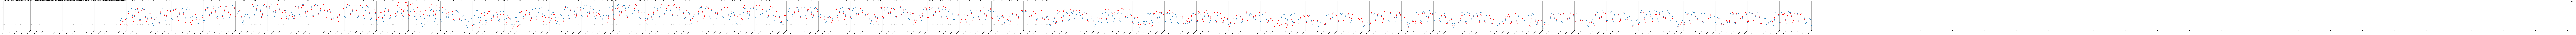

annual mape:  4.968285698573462


In [ ]:
_ = predict_annualy_plot('2022-11-01 00:00')
# annual best mape 2019-12-02 00:00: 3.4474221139726398
# annual best mape 2020-01-01 00:00: 3.4072222167818813
# annual best mape 2020-07-01 00:00: 3.4691525149862255
# annual best mape 2021-01-01 00:00: 3.6896427849946822
# annual best mape 2022-01-01 00:00: 4.01792112053822
# annual best mape 2022-11-01 00:00: 4.968285698573462
# annual best mape 2022-12-31 23:00: 5.3067974131303295

In [ ]:
pred_day_start = datetime.strptime(str('2022-01-01 00:00'), '%Y-%m-%d %H:%M')
trainY = data[['current_energy_demand']][pred_day_start:pred_day_start + timedelta(hours=one_year)].to_numpy()
len(trainY)

8761

In [ ]:
start_index = data.index.get_loc(pred_day_start)
result = data[['current_energy_demand']].iloc[start_index:start_index + one_year]
len(result)

8760